In [1]:
import petri_net_toolkit as pntk
from petri_net_toolkit.nets import *
import numpy as np
import torch
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random
from tqdm import tqdm
import rl_utils

In [2]:
env = Sorter2p_Colored_Simple('Sorter2p_Petri')

env.initialize_net()
env.reset()
env.draw_net('Sorter2p_Colored_initial.png', show_note=True)

/Users/jason/Documents/SJTU_pro/Projects/DTG/PetriNets/petri_net_toolkit/petri_nets.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pt_matrix.loc[element.name] = np.zeros(len(self.pt_matrix.columns))


{'p1': {'default': 30, 'default_error': 0}, 'p5': {'default': 0, 'default_error': 0}, 'p16': {'default': 1, 'default_error': 0}, 'p17': {'default': 0, 'default_error': 0}, 'p18': {'default': 1, 'default_error': 0}, 'p19': {'default': 0, 'default_error': 0}, 'p20': {'default': 0, 'default_error': 0}, 'p21': {'default': 1, 'default_error': 0}, 'p22': {'default': 0, 'default_error': 0}, 'p23': {'default': 0, 'default_error': 0}, 'p24': {'default': 0, 'default_error': 0}}


In [3]:
print(len(env.places))

11


In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.sigmoid(self.fc2(x))

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps      # PPO-Clip epsilon
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        bernolli = torch.distributions.Bernoulli(probs)
        action_vector = bernolli.sample().reshape(-1).numpy()
        return action_vector

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        bernoulli = torch.distributions.Bernoulli(self.actor(states))
        old_log_probs = bernoulli.log_prob(actions).sum().detach()

        for _ in range(self.epochs):
            bernoulli_ = torch.distributions.Bernoulli(self.actor(states))
            log_probs = bernoulli_.log_prob(actions).sum()
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) 
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [6]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
lmbda = 0.95
epochs = 10
eps = 0.2

In [7]:
state_dim = env.observation_space[0]
action_dim = env.action_space
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

In [8]:
return_list = []
output_traj = []
dict_list = []
output_time = []
T_list = []
for i in range(20):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            max_T = 300
            T = 0
            traj_o = []
            traj_f = []
            trig = np.zeros(env.action_dim)
            ## sample one sequence
            while (not done) and (T < max_T):
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward
                traj_o.append(env.places['p23'].token['default'])
                traj_f.append(env.places['p24'].token['default_error'])
                T += 1
                # if env.places['p22'].token['default_error'] != 0:
                print(env.places['p22'].token)
                    # print(T)
                # print(env.debugger_num, done)
                # print(next_state)
            T_list.append(T)
            output_traj.append(traj_o)
            output_time.append(env.act_time)
            return_list.append(episode_return)
            dict_list.append(transition_dict)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/7x/vkxy_bn547d757f8znyxd6rh0000gn/T/ipykernel_26533/3809666563.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 0:  18%|█▊        | 9/50 [00:00<00:00, 88.19it/s, episode=10, return=19.706]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 0:  60%|██████    | 30/50 [00:00<00:00, 94.21it/s, episode=30, return=16.568]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'defa

Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 90.06it/s, episode=50, return=2.752] 


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 1:  18%|█▊        | 9/50 [00:00<00:00, 68.64it/s, episode=60, return=-1.208]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 1:  28%|██▊       | 14/50 [00:00<00:00, 63.04it/s, episode=60, return=-1.208]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 1:  42%|████▏     | 21/50 [00:00<00:00, 63.35it/s, episode=70, return=-15.567]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 1:  58%|█████▊    | 29/50 [00:00<00:00, 56.12it/s, episode=80, return=-32.642]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 1:  68%|██████▊   | 34/50 [00:00<00:00, 51.02it/s, episode=80, return=-32.642]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 1:  82%|████████▏ | 41/50 [00:00<00:00, 54.85it/s, episode=90, return=-26.500]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 1: 100%|██████████| 50/50 [00:01<00:00, 49.32it/s, episode=100, return=-52.894]


{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'defa

Iteration 2:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:   8%|▊         | 4/50 [00:00<00:01, 32.25it/s]

{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'default_error': 2}
{'default': 1, 'defa

Iteration 2:  16%|█▌        | 8/50 [00:00<00:01, 31.72it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  26%|██▌       | 13/50 [00:00<00:01, 34.48it/s, episode=110, return=-75.219]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  42%|████▏     | 21/50 [00:00<00:00, 34.20it/s, episode=120, return=-71.136]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 2:  50%|█████     | 25/50 [00:00<00:00, 32.09it/s, episode=120, return=-71.136]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  58%|█████▊    | 29/50 [00:00<00:00, 31.83it/s, episode=120, return=-71.136]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  66%|██████▌   | 33/50 [00:01<00:00, 31.06it/s, episode=130, return=-85.541]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  78%|███████▊  | 39/50 [00:01<00:00, 32.23it/s, episode=140, return=-56.598]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  82%|████████▏ | 41/50 [00:01<00:00, 33.92it/s, episode=140, return=-56.598]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 2:  92%|█████████▏| 46/50 [00:01<00:00, 36.91it/s, episode=140, return=-56.598]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:   8%|▊         | 4/50 [00:00<00:01, 31.82it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:  16%|█▌        | 8/50 [00:00<00:01, 32.89it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:  26%|██▌       | 13/50 [00:00<00:00, 39.45it/s, episode=160, return=-44.058]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 3:  38%|███▊      | 19/50 [00:00<00:00, 45.44it/s, episode=160, return=-44.058]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:  38%|███▊      | 19/50 [00:00<00:00, 45.44it/s, episode=170, return=-40.378]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 3:  48%|████▊     | 24/50 [00:00<00:00, 38.37it/s, episode=170, return=-40.378]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 3:  58%|█████▊    | 29/50 [00:00<00:00, 36.13it/s, episode=180, return=-65.098]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 3:  76%|███████▌  | 38/50 [00:01<00:00, 36.85it/s, episode=180, return=-65.098]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 3:  84%|████████▍ | 42/50 [00:01<00:00, 33.88it/s, episode=190, return=-45.511]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3:  92%|█████████▏| 46/50 [00:01<00:00, 32.45it/s, episode=190, return=-45.511]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 3: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s, episode=200, return=-30.177]


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:   8%|▊         | 4/50 [00:00<00:01, 37.64it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:  16%|█▌        | 8/50 [00:00<00:01, 33.99it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:  24%|██▍       | 12/50 [00:00<00:01, 36.49it/s, episode=210, return=-34.437]

{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 4:  34%|███▍      | 17/50 [00:00<00:00, 36.72it/s, episode=210, return=-34.437]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 4:  46%|████▌     | 23/50 [00:00<00:00, 43.36it/s, episode=220, return=-23.934]

{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 4:  58%|█████▊    | 29/50 [00:00<00:00, 43.96it/s, episode=230, return=-22.361]

{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:  66%|██████▌   | 33/50 [00:00<00:00, 41.12it/s, episode=230, return=-22.361]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:  76%|███████▌  | 38/50 [00:00<00:00, 36.14it/s, episode=230, return=-22.361]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4:  78%|███████▊  | 39/50 [00:01<00:00, 36.14it/s, episode=240, return=-41.977]

{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 4:  96%|█████████▌| 48/50 [00:01<00:00, 40.31it/s, episode=240, return=-41.977]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 4: 100%|██████████| 50/50 [00:01<00:00, 39.28it/s, episode=250, return=-30.095]


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 5:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 5:   6%|▌         | 3/50 [00:00<00:01, 23.87it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 5:  20%|██        | 10/50 [00:00<00:00, 47.11it/s, episode=260, return=-8.658]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 5:  32%|███▏      | 16/50 [00:00<00:00, 50.12it/s, episode=260, return=-8.658]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'defa

Iteration 5:  38%|███▊      | 19/50 [00:00<00:00, 50.12it/s, episode=270, return=-5.797]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 5:  48%|████▊     | 24/50 [00:00<00:00, 60.23it/s, episode=270, return=-5.797]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 5:  62%|██████▏   | 31/50 [00:00<00:00, 54.43it/s, episode=280, return=1.616] 

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 5:  78%|███████▊  | 39/50 [00:00<00:00, 61.50it/s, episode=290, return=6.453]

{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'defa

Iteration 5:  94%|█████████▍| 47/50 [00:00<00:00, 65.63it/s, episode=290, return=6.453]

{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 6:  18%|█▊        | 9/50 [00:00<00:00, 82.21it/s, episode=310, return=13.603]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 6:  38%|███▊      | 19/50 [00:00<00:00, 64.19it/s, episode=320, return=13.650]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 6:  58%|█████▊    | 29/50 [00:00<00:00, 81.30it/s, episode=330, return=14.523]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 6:  78%|███████▊  | 39/50 [00:00<00:00, 81.86it/s, episode=340, return=21.351]

{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'defa

Iteration 6:  96%|█████████▌| 48/50 [00:00<00:00, 85.36it/s, episode=340, return=21.351]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'default_error': 4}
{'default': 0, 'defa

Iteration 7:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 7:  18%|█▊        | 9/50 [00:00<00:00, 85.29it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 7:  18%|█▊        | 9/50 [00:00<00:00, 85.29it/s, episode=360, return=14.796]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'defa

Iteration 7:  38%|███▊      | 19/50 [00:00<00:00, 79.33it/s, episode=370, return=10.344]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 7:  52%|█████▏    | 26/50 [00:00<00:00, 65.06it/s, episode=370, return=10.344]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 7:  58%|█████▊    | 29/50 [00:00<00:00, 65.06it/s, episode=380, return=8.442] 

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 7:  66%|██████▌   | 33/50 [00:00<00:00, 65.03it/s, episode=380, return=8.442]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 7:  80%|████████  | 40/50 [00:00<00:00, 65.98it/s, episode=390, return=4.022]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 7:  94%|█████████▍| 47/50 [00:00<00:00, 48.16it/s, episode=390, return=4.022]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 57.32it/s, episode=400, return=-29.438]


{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 8:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 8:  12%|█▏        | 6/50 [00:00<00:00, 57.39it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 8:  18%|█▊        | 9/50 [00:00<00:00, 57.39it/s, episode=410, return=-13.898]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 8:  28%|██▊       | 14/50 [00:00<00:00, 65.43it/s, episode=410, return=-13.898]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 8:  42%|████▏     | 21/50 [00:00<00:00, 45.67it/s, episode=420, return=-32.198]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 8:  58%|█████▊    | 29/50 [00:00<00:00, 55.07it/s, episode=430, return=-4.753] 

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 8:  78%|███████▊  | 39/50 [00:00<00:00, 61.24it/s, episode=440, return=7.356] 

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 57.41it/s, episode=450, return=10.298]


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 9:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 9:  18%|█▊        | 9/50 [00:00<00:00, 88.31it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 9:  18%|█▊        | 9/50 [00:00<00:00, 88.31it/s, episode=460, return=9.168]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 9:  36%|███▌      | 18/50 [00:00<00:00, 59.22it/s, episode=460, return=9.168]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 9:  38%|███▊      | 19/50 [00:00<00:00, 59.22it/s, episode=470, return=16.602]

{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 9:  52%|█████▏    | 26/50 [00:00<00:00, 65.67it/s, episode=470, return=16.602]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 9:  58%|█████▊    | 29/50 [00:00<00:00, 65.67it/s, episode=480, return=12.009]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 9:  68%|██████▊   | 34/50 [00:00<00:00, 60.86it/s, episode=480, return=12.009]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 9:  78%|███████▊  | 39/50 [00:00<00:00, 60.86it/s, episode=490, return=14.485]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 68.07it/s, episode=500, return=16.043]


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 10:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'defa

Iteration 10:  20%|██        | 10/50 [00:00<00:00, 90.54it/s, episode=510, return=15.081]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 10:  40%|████      | 20/50 [00:00<00:00, 66.29it/s, episode=520, return=8.227] 

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'defa

Iteration 10:  58%|█████▊    | 29/50 [00:00<00:00, 74.06it/s, episode=520, return=8.227]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'defa

Iteration 10:  58%|█████▊    | 29/50 [00:00<00:00, 74.06it/s, episode=530, return=15.154]

{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 0, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 1, 'default_error': 5}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'defa

Iteration 10:  78%|███████▊  | 39/50 [00:00<00:00, 63.14it/s, episode=540, return=20.652]

{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 7}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 8}
{'default': 0, 'default_error': 9}
{'default': 0, 'default_error': 9}
{'default': 0, 'default_error': 9}
{'default': 0, 'default_error': 9}
{'default': 0, 'defa

Iteration 10: 100%|██████████| 50/50 [00:00<00:00, 72.74it/s, episode=550, return=23.071]


{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'defa

Iteration 11:   0%|          | 0/50 [00:00<?, ?it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 11:  10%|█         | 5/50 [00:00<00:00, 46.30it/s]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'defa

Iteration 11:  18%|█▊        | 9/50 [00:00<00:00, 46.30it/s, episode=560, return=15.827]

{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'default_error': 3}
{'default': 0, 'defa

Iteration 11:  26%|██▌       | 13/50 [00:00<00:00, 65.25it/s, episode=560, return=15.827]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 11:  38%|███▊      | 19/50 [00:00<00:00, 65.25it/s, episode=570, return=17.749]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 1, 'default_error': 1}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

Iteration 11:  44%|████▍     | 22/50 [00:00<00:00, 62.07it/s, episode=570, return=17.749]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 0, 'default_error': 2}
{'default': 1, 'defa

Iteration 11:  60%|██████    | 30/50 [00:00<00:00, 68.20it/s, episode=580, return=24.595]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'default_error': 1}
{'default': 0, 'defa

Iteration 11:  84%|████████▍ | 42/50 [00:00<00:00, 70.62it/s, episode=590, return=26.090]

{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 1, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'default_error': 0}
{'default': 0, 'defa

KeyboardInterrupt: 

In [ ]:
k = 100
for i in range(len(dict_list[k]['states'])):
    print(dict_list[k]['states'][i])

[30  0  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[29  1  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[28  1  1  0  1  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[28  1  1  0  1  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[27  1  1  0  0  0  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
[27  1  1  0  0  0  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]


In [ ]:
print(len(dict_list[2]['states']))

20


In [ ]:
# ms = 0
# mk = 0
# for i in range(len(dict_list)):
#     if len(dict_list[i]['states']) > ms:
#         ms = len(dict_list[i]['states'])
#         mk = i

# print(ms)
# mk = ms
# for i in range(len(dict_list[mk]['states'])):
#     print(dict_list[mk]['states'][i])

In [ ]:
for a in env.actions:
    print(a.name)
ma = 20
for i in range(len(dict_list[ma]['actions'])):
    print(dict_list[ma]['actions'][i])

t11
t12
t13
t14
t15
t16
[1. 0. 1. 0. 1. 1.]
[0. 0. 1. 1. 1. 0.]
[0. 0. 1. 1. 1. 0.]
[0. 0. 1. 1. 1. 1.]
[0. 0. 1. 0. 1. 1.]
[1. 0. 1. 0. 1. 1.]
[0. 0. 1. 0. 1. 1.]
[1. 0. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 1.]
[0. 0. 1. 0. 1. 0.]
[0. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 0.]
[1. 0. 1. 1. 1. 0.]
[0. 0. 1. 1. 1. 0.]
[1. 0. 1. 1. 1. 1.]
[1. 0. 1. 1. 1. 1.]
[1. 1. 1. 0. 1. 0.]
[1. 0. 0. 0. 1. 1.]
[0. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 1. 0.]
[1. 0. 1. 1. 1. 0.]
[0. 0. 1. 0. 1. 1.]
[1. 1. 1. 1. 1. 0.]
[0. 0. 1. 1. 1. 0.]
[0. 1. 1. 1. 0. 0.]
[0. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 1. 0.]


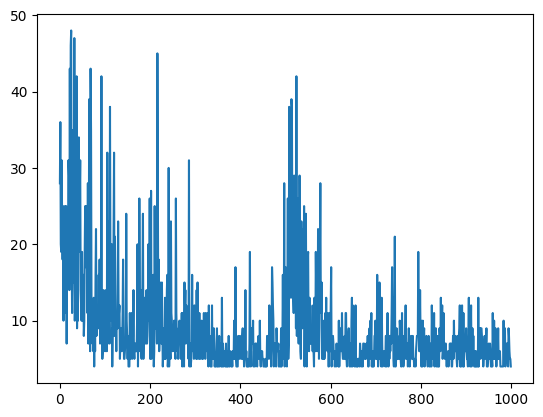

In [ ]:
# ======= plot T =======
plt.plot(range(len(T_list)), T_list)

1000


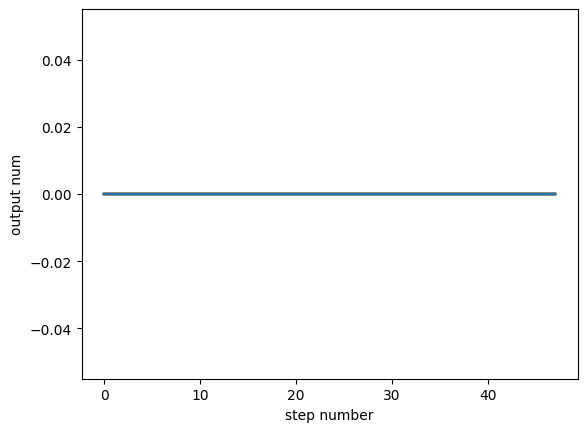

In [ ]:
# ======= plot output traj =======
max_traj = max(len(traj) for traj in output_traj)
step_num = range(max_traj)
for traj in output_traj:
    traj.extend([traj[-1]] * (max_traj - len(traj)))
    
max_step = 200
for i in range(40):
    plt.plot(step_num[:max_step], output_traj[i][:max_step])

plt.plot(step_num[:max_step], output_traj[-1][:max_step])
plt.xlabel('step number')
plt.ylabel('output num')
print(len(output_traj))

18.47983336066976


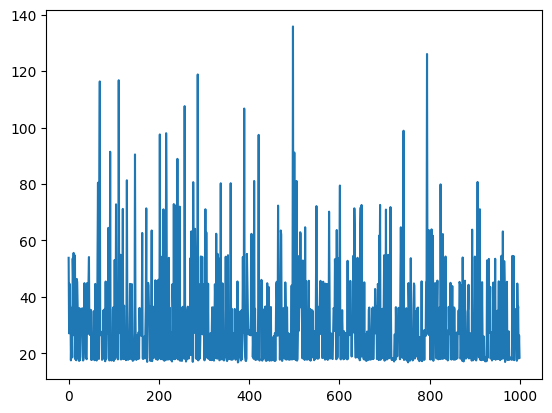

In [ ]:
# ======= plot min finish time =======

print(output_time[-1])
plt.plot(range(len(output_time)), output_time)

[34.14909646939123, 4.910326764316972, 30.87774663971359, 22.447907081087827, 15.745710504383345, 4.002947581710174, 13.785630561283096, 7.502483776359616, 12.718043912300747, 40.893360284569695, 37.553523295726336, 37.2034196311175, 19.77809879903557, 27.599816750186676, 39.34198658877845, 13.265006361238417, 20.31618331484967, 9.13977560897902, 32.34852415648679, 27.812914375469376, 16.12138699542648, 9.333230288398129, -5.881729406990156, 6.3544609328353365, 8.816363069656056, -11.397463178031915, 15.688644318439561, 21.242078020746778, 20.097079019433504, 19.308621702324324, 7.696723184559021, 7.407941020096969, -8.291563066936172, 12.70876136435474, 17.62988081702209, 25.527030181718207, 17.902687433638416, 10.251396847971456, 12.992491753819259, 4.73144038667196, 10.105699271917027, 22.251392148290495, 1.6352524398870152, 15.402021195885283, 23.80370223321455, 29.623985491218466, 15.546530132121031, 20.893611793542068, 22.80762603369446, 22.262447143451528, 10.150876038740616, 23

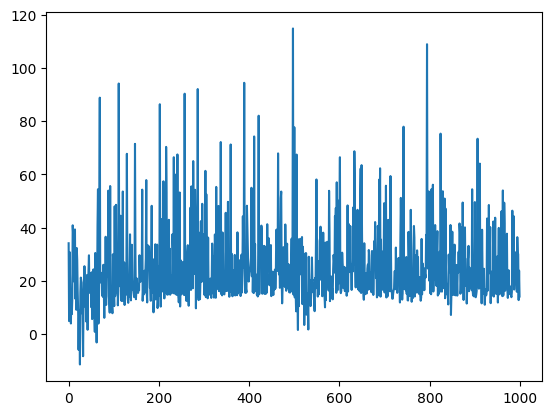

In [ ]:
print(return_list)
plt.plot(range(len(return_list)), return_list)